In [2]:
import librosa
import numpy as np
import os
import matplotlib.pyplot as plt
import soundfile as sf
import pandas as pd
import torch
import json
import re

In [3]:
# Load audio files
audio_dir = "dataset\자유대화 음성(일반남녀)\Training\일반남여_일반통합01_F_0.0baesubin_26_수도권_실내"
audio_files = os.listdir(audio_dir)
audio_files[0]

'일반남여_일반통합01_F_0.0baesubin_26_수도권_실내_00002.wav'

In [4]:
signal, sr = librosa.load(os.path.join(audio_dir, audio_files[0]), sr=16000)
signal

array([-3.0517578e-05,  0.0000000e+00,  3.0517578e-05, ...,
       -1.1291504e-03, -9.7656250e-04, -8.2397461e-04], dtype=float32)

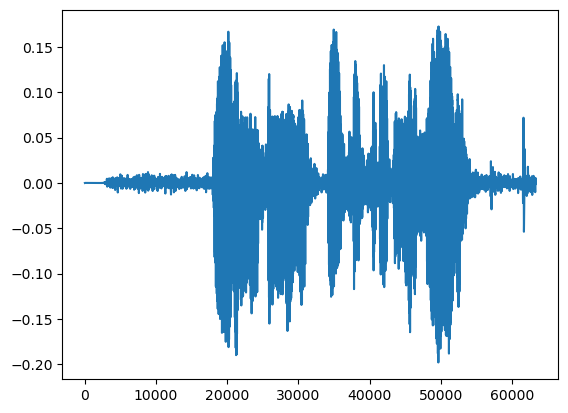

In [5]:
plt.plot(signal)

In [6]:
emphasized = librosa.effects.preemphasis(signal)
emphasized

array([-9.1552734e-05,  2.9602052e-05,  3.0517578e-05, ...,
        8.4533705e-05,  1.1871336e-04,  1.2329104e-04], dtype=float32)

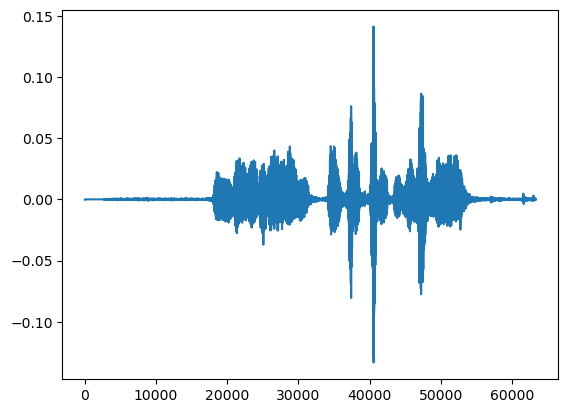

In [7]:
plt.plot(emphasized)

In [8]:
# windowing
w = np.hanning(emphasized.size)
windowed = w * emphasized
windowed

array([-0.00000000e+00,  7.27971883e-14,  3.00194584e-13, ...,
        8.31539134e-13,  2.91939185e-13,  0.00000000e+00])

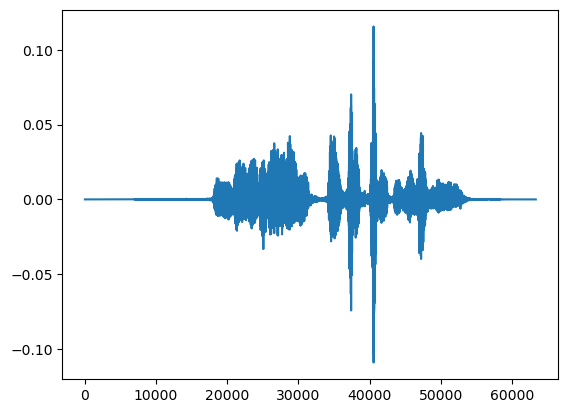

In [9]:
plt.plot(windowed)

### windowed FFT

In [10]:
Fs = 16000
T = 1/Fs

Y = np.fft.fft(windowed)
amp = abs(Y) * (2/len(Y))
freq = np.fft.fftfreq(len(Y), T)

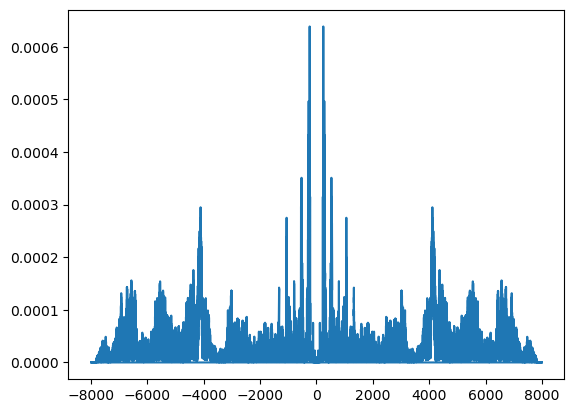

In [11]:
plt.plot(freq, amp)

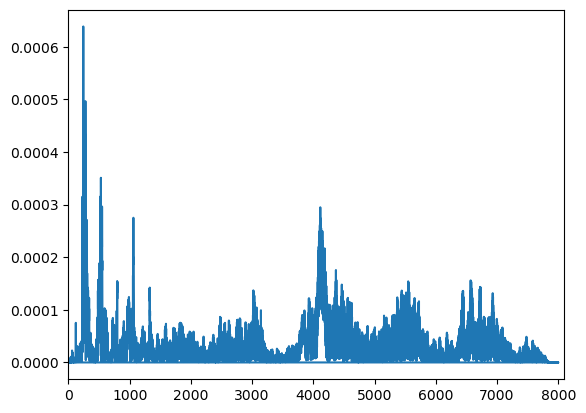

In [12]:
plt.xlim(0, 8100)
plt.plot(freq, amp)

### normal FFT

In [13]:
Fs = 16000
T = 1/Fs

Y = np.fft.fft(emphasized)
amp = abs(Y) * (2/len(Y))
freq = np.fft.fftfreq(len(Y), T)

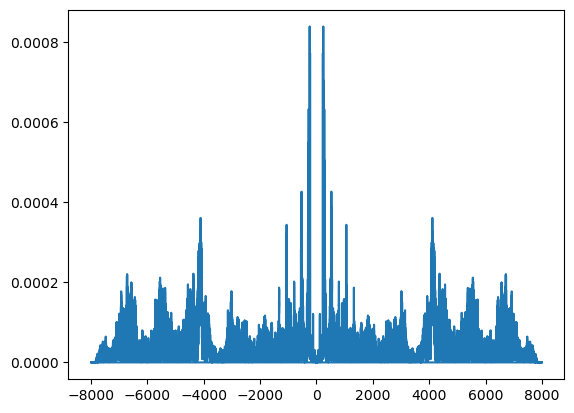

In [14]:
plt.plot(freq, amp)

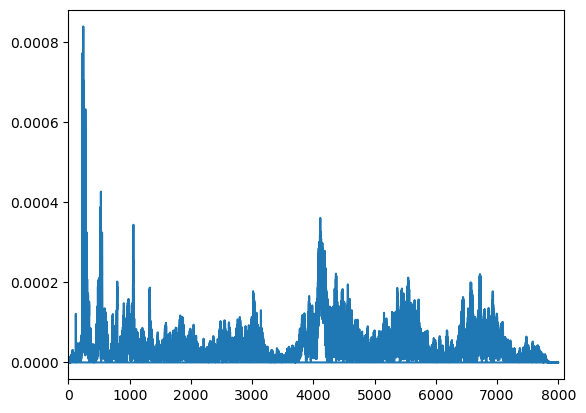

In [15]:
plt.xlim(0, 8100)
plt.plot(freq, amp)

### 여기서 부터 찐임

In [19]:
def make_base_dataset():
    # Load audio files
    base_dir = "dataset\자유대화 음성(일반남녀)\Training"
    folders = os.listdir(base_dir)

    dataset = []
    for folder in folders:
        if folder == "label":
            continue
        sub_dir = os.path.join(base_dir, folder)
        if not os.path.isdir(sub_dir):
            continue

        audio_dir = sub_dir
        audio_files = os.listdir(audio_dir)    

        label_dir =  os.path.join(base_dir, "label", folder)
        label_files = os.listdir(label_dir)

        # Apply pre-emphasis and windowing to each audio file
        for file, label in zip(audio_files, label_files):
            # Load audio file
            signal, sr = librosa.load(os.path.join(audio_dir, file), sr=16000)

            # Apply pre-emphasis
            emphasized = librosa.effects.preemphasis(signal)

            # Set window
            w = np.hanning(emphasized.size)

            # Apply windowing
            windowed = w * emphasized

            # Get the label
            with open(os.path.join(label_dir, label), "r", encoding="UTF-8") as js:
                l = json.load(js)
                sentence = l['발화정보']['stt']
                sentence = re.sub("[(NO:)]|[(SP:)]", "", sentence) # 마킹 태그 제거
                sentence = re.sub("[.]|[,]", "", sentence) # 마침표, 쉼표 제거
                dataset.append([windowed, sentence])

    df = pd.DataFrame(dataset, columns=['data','label'])
    return df

In [ ]:
# 길이가 제각기 다르므로 가장 긴 길이의 데이터를 기준으로 패딩을 채운다 (RNN의 경우 이 과정이 필요없다)
maximum = [len(row) for row in df['data']] / len()
for i, row in enumerate(df['data'].copy(deep=True)):
    row = np.pad(row, (0, maximum-len(row)), 'constant')
    df['data'][i] = row

### MFCC 추출

In [20]:
def get_mfcc(df):
    mfccs = []
    for j, i in enumerate(df['data']):
        extracted_features = librosa.feature.mfcc(y=i,sr=16000,n_mfcc=40)
        mfccs.append([extracted_features, df['label'][j]])
    df2 = pd.DataFrame(mfccs, columns=['data','label'])
    return df2

In [18]:
df2['data'][0].shape

(40, 124)

In [21]:
class SpeechDataset(torch.utils.data.Dataset):
    def __init__(self):
        df = get_mfcc(make_base_dataset())
        self.x = get_mfcc(df['data'])
        self.y = df['label']
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.x[idx])
        y = self.y[idx]